In [2]:
# --- Config ---
import sys
import os
sys.path.append(os.path.abspath(".."))
from modules.config_utils import load_config
CONFIG_PATH = "../config.yml"
CONFIG = load_config(str(CONFIG_PATH))
print("Output directory:", CONFIG.get("output_dir"))

Loaded config keys: ['aoi', 'infrastructure_inputs', 'output_dir', 'hazards']
Output directory: ../data/todelete


In [3]:
# --- Load AOI and infrastructure (by type) ---
import geopandas as gpd
import pandas as pd
from modules.crs_utils import harmonize_crs

# AOI
aoi = gpd.read_file(CONFIG["aoi"])
aoi_union = aoi.union_all()

# Infrastructure
points_by_type = {}
lines_by_type = {}

for name, path in CONFIG["infrastructure_inputs"]["points"].items():
    if path is not None:
        points_by_type[name] = gpd.read_file(path)

for name, path in CONFIG["infrastructure_inputs"]["lines"].items():
    if path is not None:
        lines_by_type[name] = gpd.read_file(path)

# Harmonize to AOI CRS + clip + tag
for name, gdf in points_by_type.items():
    gdf, = harmonize_crs([gdf], aoi.crs)
    gdf = gdf[gdf.geometry.within(aoi_union)]
    gdf["infra_type"] = name
    points_by_type[name] = gdf

for name, gdf in lines_by_type.items():
    gdf, = harmonize_crs([gdf], aoi.crs)
    gdf = gdf[gdf.geometry.intersects(aoi_union)]
    gdf["infra_type"] = name
    lines_by_type[name] = gdf

# Union for quick previews
all_points = gpd.GeoDataFrame(pd.concat(points_by_type.values(), ignore_index=True), crs=aoi.crs) if points_by_type else None
all_lines  = gpd.GeoDataFrame(pd.concat(lines_by_type.values(),  ignore_index=True), crs=aoi.crs) if lines_by_type else None

print({k: len(v) for k, v in points_by_type.items()})
print({k: len(v) for k, v in lines_by_type.items()})

{'transformer': 4, 'tower': 26273, 'substations': 212}
{'lv': 143, 'hv': 276}


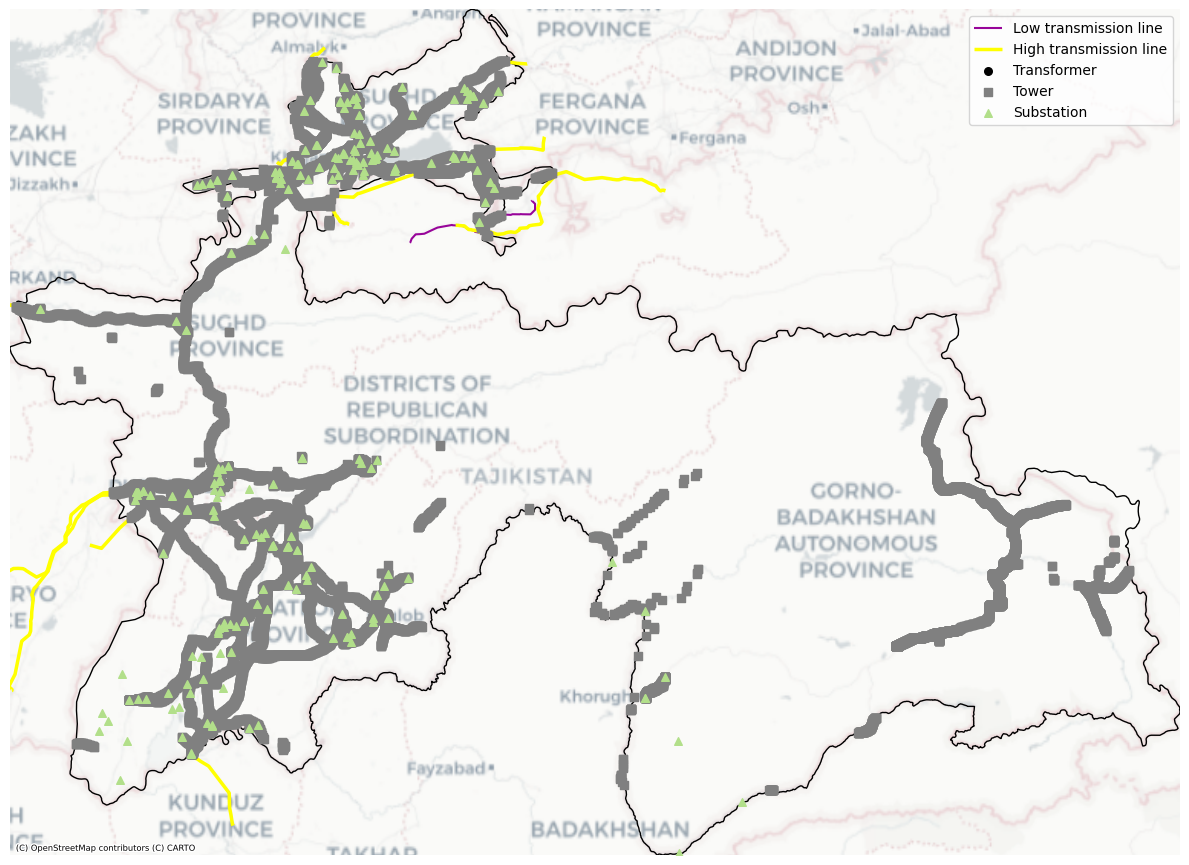

Saved: ../data/todelete/00_initial_network_map.png


In [4]:
# --- Show initial network map (by type) ---
from modules.plotting import plot_initial_map_by_type
from pathlib import Path
out_dir = Path(CONFIG["output_dir"])
out_dir.mkdir(parents=True, exist_ok=True)

initial_map_path = out_dir / "00_initial_network_map.png"
plot_initial_map_by_type(
    aoi=aoi,
    points_by_type=points_by_type,
    lines_by_type=lines_by_type,
    output_path=str(initial_map_path),
)
print("Saved:", initial_map_path)

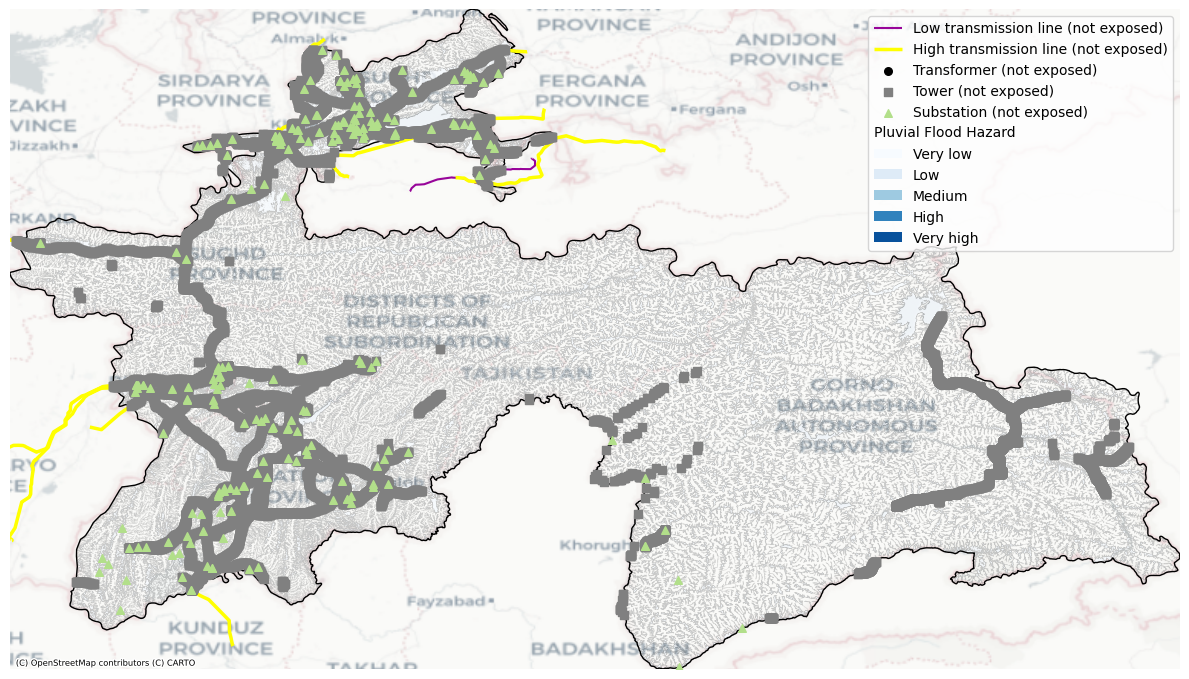

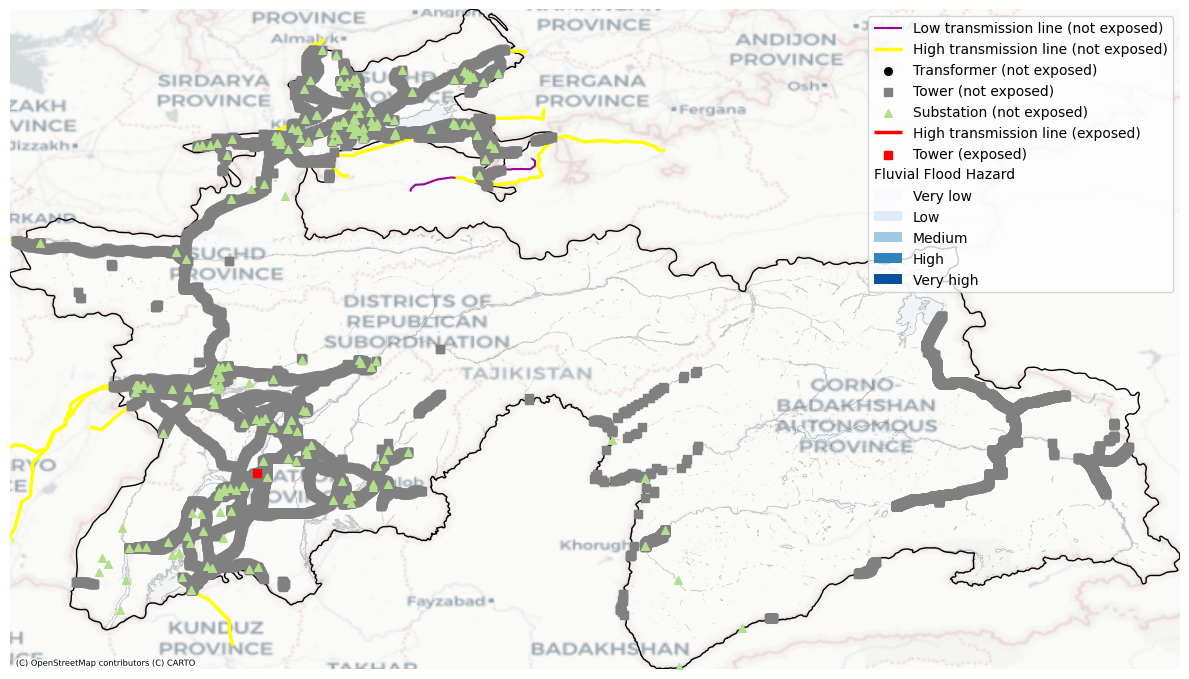

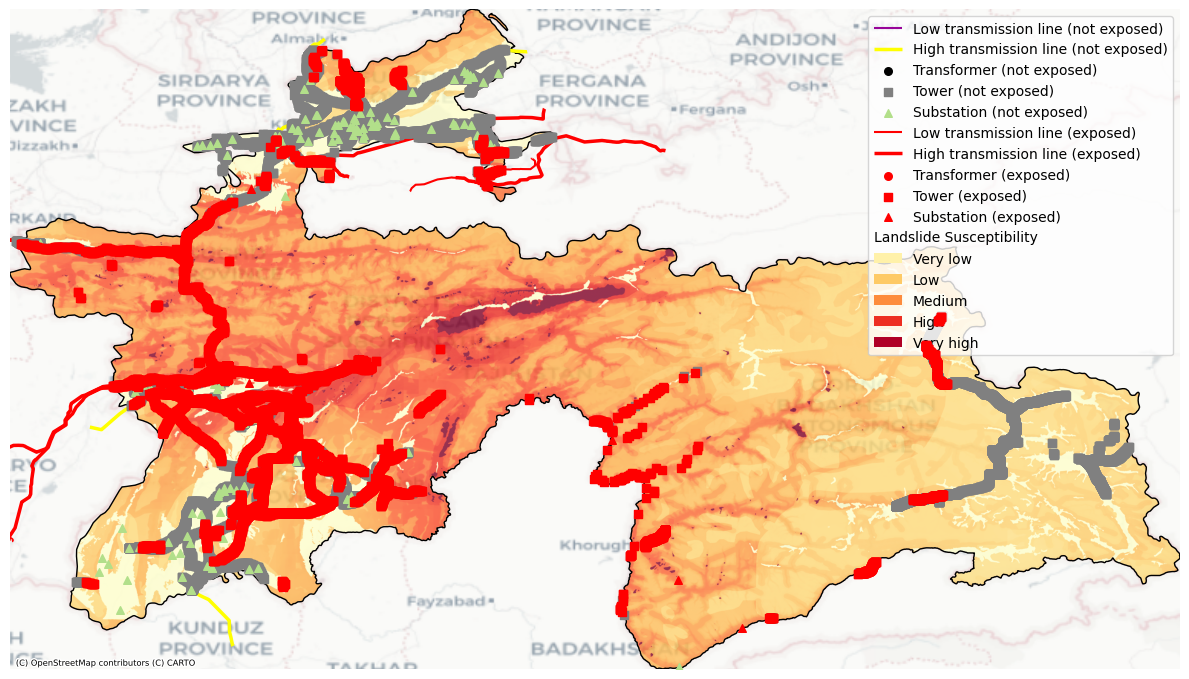


--- Clipping and saving earthquake raster ---


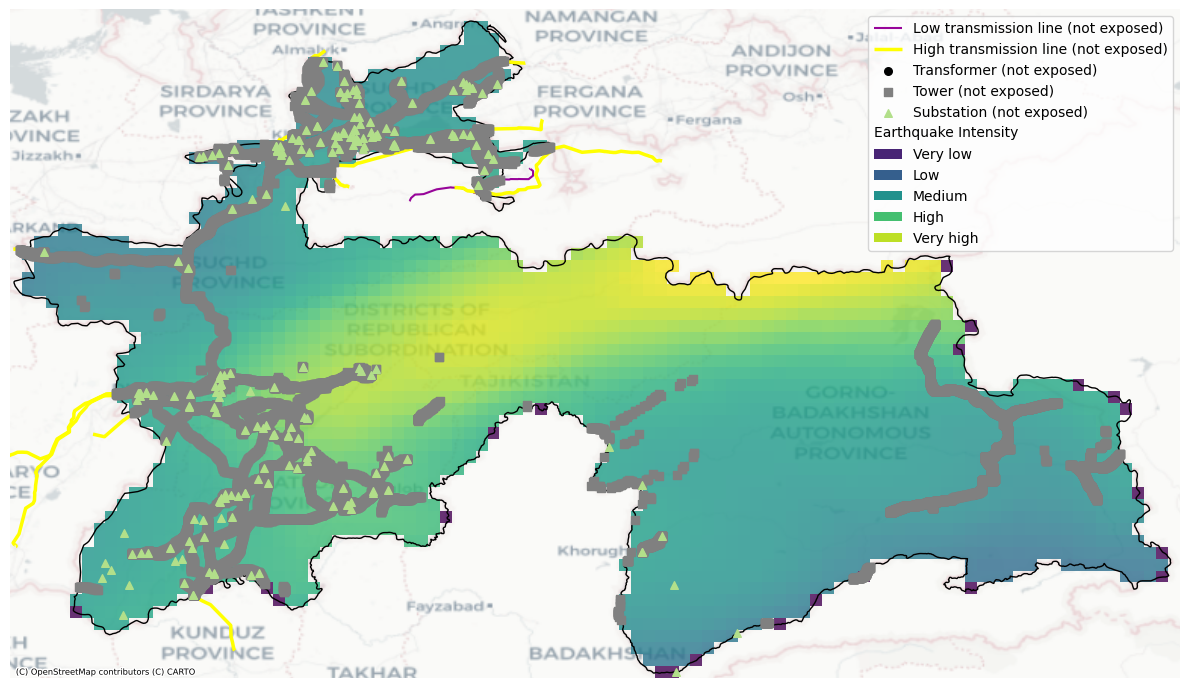

Available hazard results: ['pluvial_flood', 'fluvial_flood', 'landslide', 'earthquake']


In [5]:
# --- Run raster-based exposure (pluvial_flood / fluvial_flood / landslide / earthquake, etc.) ---
from modules.raster_exposure import process_raster_exposures

# Number of samples along each line to test exposure
SAMPLE_POINTS_PER_LINE = int(CONFIG.get("sample_points_per_line", 10))

results = process_raster_exposures(
    config=CONFIG,
    aoi=aoi,
    points_by_type=points_by_type,
    lines_by_type=lines_by_type,
    sample_points_per_line=SAMPLE_POINTS_PER_LINE
)
print("Available hazard results:", list(results.keys()))

In [6]:
# --- Quick preview: show the first few exposed features for each hazard (if any) ---
import pandas as pd

def head_if_any(gdf, n=5):
    if gdf is None or len(gdf) == 0:
        return pd.DataFrame({"note": ["<empty>"]})
    return gdf.head(n).drop(columns=[c for c in gdf.columns if c.startswith("geometry")], errors="ignore")

for hz, payload in results.items():
    print(f"\n### {hz} ###")
    pts = payload.get("points_exposed")
    lns = payload.get("lines_exposed")
    print("Points:")
    display(head_if_any(pts))
    print("Lines:")
    display(head_if_any(lns))


### pluvial_flood ###
Points:


full_id      osm_id osm_type        power    transforme addr_postc  \
0   w229912903   229912903      way  transformer          None       None   
1   w229912904   229912904      way  transformer          None       None   
2   w375669569   375669569      way  transformer  distribution       None   
3   w575681211   575681211      way  transformer  distribution       None   
4  n2029124123  2029124123     node        tower          None       None   

  name_tg addr_stree addr_house addr_city  ... phone opening_ho email  \
0    None       None       None      None  ...   NaN        NaN   NaN   
1    None       None       None      None  ...   NaN        NaN   NaN   
2    None       None       None      None  ...   NaN        NaN   NaN   
3    None       None       None      None  ...   NaN        NaN   NaN   
4     NaN       None       None      None  ...  None       None  None   

  man_made material line_manag triple_tow design      haz_val exposed  
0      NaN      NaN        NaN        NaN    NaN     0.000000   False  
1      NaN      NaN        NaN        NaN    NaN -9999.000000   False  
2      NaN      NaN        NaN        NaN    NaN     0.002494   False  
3      NaN      NaN        NaN        NaN    NaN     0.013998   False  
4     None     None       None       None   None    -1.000000   False  

[5 rows x 67 columns]

Lines:


full_id     osm_id osm_type power transforme addr_postc name_tg  \
0  w241853510  241853510      way  line       None       None    None   
1  w242622885  242622885      way  line       None       None    None   
2  w242622888  242622888      way  line       None       None    None   
3  w300745787  300745787      way  line       None       None    None   
4  w329405775  329405775      way  line       None       None    None   

  addr_stree addr_house addr_city  ... circuits cables frequency substation  \
0       None       None      None  ...        1      3      None       None   
1       None       None      None  ...     None   None        50       None   
2       None       None      None  ...        2      6        50       None   
3       None       None      None  ...        1      3      None       None   
4       None       None      None  ...        2      6      None       None   

  surface layer  foot voltage infra_type exposed  
0    None  None  None   35000         lv   False  
1    None  None  None  110000         lv   False  
2    None  None  None  110000         lv   False  
3    None  None  None   35000         lv   False  
4    None  None  None  110000         lv   False  

[5 rows x 36 columns]


### fluvial_flood ###
Points:


full_id      osm_id osm_type        power    transforme addr_postc  \
0   w229912903   229912903      way  transformer          None       None   
1   w229912904   229912904      way  transformer          None       None   
2   w375669569   375669569      way  transformer  distribution       None   
3   w575681211   575681211      way  transformer  distribution       None   
4  n2029124123  2029124123     node        tower          None       None   

  name_tg addr_stree addr_house addr_city  ... phone opening_ho email  \
0    None       None       None      None  ...   NaN        NaN   NaN   
1    None       None       None      None  ...   NaN        NaN   NaN   
2    None       None       None      None  ...   NaN        NaN   NaN   
3    None       None       None      None  ...   NaN        NaN   NaN   
4     NaN       None       None      None  ...  None       None  None   

  man_made material line_manag triple_tow design haz_val exposed  
0      NaN      NaN        NaN        NaN    NaN -9999.0   False  
1      NaN      NaN        NaN        NaN    NaN -9999.0   False  
2      NaN      NaN        NaN        NaN    NaN -9999.0   False  
3      NaN      NaN        NaN        NaN    NaN -9999.0   False  
4     None     None       None       None   None    -1.0   False  

[5 rows x 67 columns]

Lines:


full_id     osm_id osm_type power transforme addr_postc name_tg  \
0  w241853510  241853510      way  line       None       None    None   
1  w242622885  242622885      way  line       None       None    None   
2  w242622888  242622888      way  line       None       None    None   
3  w300745787  300745787      way  line       None       None    None   
4  w329405775  329405775      way  line       None       None    None   

  addr_stree addr_house addr_city  ... circuits cables frequency substation  \
0       None       None      None  ...        1      3      None       None   
1       None       None      None  ...     None   None        50       None   
2       None       None      None  ...        2      6        50       None   
3       None       None      None  ...        1      3      None       None   
4       None       None      None  ...        2      6      None       None   

  surface layer  foot voltage infra_type exposed  
0    None  None  None   35000         lv   False  
1    None  None  None  110000         lv   False  
2    None  None  None  110000         lv   False  
3    None  None  None   35000         lv   False  
4    None  None  None  110000         lv   False  

[5 rows x 36 columns]


### landslide ###
Points:


full_id      osm_id osm_type        power    transforme addr_postc  \
0   w229912903   229912903      way  transformer          None       None   
1   w229912904   229912904      way  transformer          None       None   
2   w375669569   375669569      way  transformer  distribution       None   
3   w575681211   575681211      way  transformer  distribution       None   
4  n2029124123  2029124123     node        tower          None       None   

  name_tg addr_stree addr_house addr_city  ... phone opening_ho email  \
0    None       None       None      None  ...   NaN        NaN   NaN   
1    None       None       None      None  ...   NaN        NaN   NaN   
2    None       None       None      None  ...   NaN        NaN   NaN   
3    None       None       None      None  ...   NaN        NaN   NaN   
4     NaN       None       None      None  ...  None       None  None   

  man_made material line_manag triple_tow design   haz_val exposed  
0      NaN      NaN        NaN        NaN    NaN  0.581563    True  
1      NaN      NaN        NaN        NaN    NaN  0.629928    True  
2      NaN      NaN        NaN        NaN    NaN  0.588059    True  
3      NaN      NaN        NaN        NaN    NaN  0.000000   False  
4     None     None       None       None   None  0.659256    True  

[5 rows x 67 columns]

Lines:


full_id     osm_id osm_type power transforme addr_postc name_tg  \
0  w241853510  241853510      way  line       None       None    None   
1  w242622885  242622885      way  line       None       None    None   
2  w242622888  242622888      way  line       None       None    None   
3  w300745787  300745787      way  line       None       None    None   
4  w329405775  329405775      way  line       None       None    None   

  addr_stree addr_house addr_city  ... circuits cables frequency substation  \
0       None       None      None  ...        1      3      None       None   
1       None       None      None  ...     None   None        50       None   
2       None       None      None  ...        2      6        50       None   
3       None       None      None  ...        1      3      None       None   
4       None       None      None  ...        2      6      None       None   

  surface layer  foot voltage infra_type exposed  
0    None  None  None   35000         lv   False  
1    None  None  None  110000         lv   False  
2    None  None  None  110000         lv    True  
3    None  None  None   35000         lv   False  
4    None  None  None  110000         lv   False  

[5 rows x 36 columns]


### earthquake ###
Points:


note
0  <empty>

Lines:


note
0  <empty>